# Customer Segmentation/Customer Behaviour Exploration

#### This project will analyze the behaviour of customer and catagorize each customer to be paid attention furtherly. 

In [1]:
# import_useful_libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.cluster import MiniBatchKMeans, KMeans 
from sklearn.metrics.pairwise import pairwise_distances_argmin 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# read_useful_dataset
data=pd.read_excel('C:\\Users\\imnab\\Downloads\\online_retail.xlsx')

### Data_Preprocessing

#### Let's look at the customer dataset.

In [3]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [5]:
data.dropna(axis=0, inplace=True)

In [6]:
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
data.shape

(417534, 8)

In [10]:
data = data[~data["Invoice"].str.contains("C", na=False)]

In [11]:
data.shape

(407695, 8)

In [12]:
data.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,407695.0,13.586686,96.842229,1.0,1.00,1.00,2.00,5.00,12.00,36.0,144.00,19152.0
Price,407695.0,3.294188,34.756655,0.0,0.42,0.65,1.25,1.95,4.25,8.5,14.95,10953.5
Customer ID,407695.0,15368.504107,1679.795700,12346.0,12731.00,13044.00,13997.00,15321.00,17138.00,17913.0,18196.00,18287.0


In [13]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [14]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [15]:
replace_with_thresholds(data, "Quantity")
replace_with_thresholds(data, "Price")

In [16]:
data.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,407695.0,11.907043,28.729349,1.0,1.00,1.00,2.00,5.00,12.00,36.0,144.00,358.50
Price,407695.0,3.005391,3.250550,0.0,0.42,0.65,1.25,1.95,4.25,8.5,14.95,36.94
Customer ID,407695.0,15368.504107,1679.795700,12346.0,12731.00,13044.00,13997.00,15321.00,17138.00,17913.0,18196.00,18287.00


In [17]:
data["TotalPrice"] = data["Quantity"] * data["Price"]

In [18]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


#### To define recency, we need to find the range of time from latest purchase to each purchase time on the dataset.
#### After that, we define frequent by summing up ordered items of each customer
#### To define monetary we sum up ordered items values of each customer.

In [19]:
print('Min:{}; Max:{}'.format(min(data.InvoiceDate), max(data.InvoiceDate)))

Min:2009-12-01 07:45:00; Max:2010-12-09 20:01:00


In [20]:
snapshot_date = max(data.InvoiceDate) + dt.timedelta(days=1)

In [21]:
snapshot_date

Timestamp('2010-12-10 20:01:00')

In [22]:
# Aggregate data on a customer level
RFM_data = data.groupby(['Customer ID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,'Invoice': 'count','TotalPrice': 'sum'})
# Rename columns for easier interpretation
RFM_data.rename(columns = {'InvoiceDate': 'Recency','Invoice': 'Frequency','TotalPrice': 'MonetaryValue'}, inplace=True)
# Check the first rows
RFM_data.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2295.02
12351.0,11,21,300.93


In [23]:
RFM_data[~((RFM_data["MonetaryValue"]) > 0 & (RFM_data["Frequency"] > 0))]

,Recency,Frequency,MonetaryValue
Customer ID,,,
14103.0,301,1,0.0
14827.0,301,1,0.0


In [24]:
RFM_data = RFM_data[(RFM_data['MonetaryValue'] > 0)]

In [25]:
RFM_data.head()

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,165,33,372.86
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,102,2295.02
12351.0,11,21,300.93


#### Next, we want to rank each customer for each criteria. There will be rank 1 to 5, with rank 1 as the highest and rank 5 as the lowest

In [26]:
r_labels = range(5, 0, -1)
r_quartiles = pd.qcut(RFM_data['Recency'], 5, labels = r_labels)
RFM_data = RFM_data.assign(R = r_quartiles.values)
f_labels = range(1,6)
m_labels = range(1,6)
f_quartiles = pd.qcut(RFM_data['Frequency'], 5, labels = f_labels)
m_quartiles = pd.qcut(RFM_data['MonetaryValue'], 5, labels = m_labels)
RFM_data = RFM_data.assign(F = f_quartiles.values)
RFM_data = RFM_data.assign(M = m_quartiles.values)

In [27]:
RFM_data.head()

,Recency,Frequency,MonetaryValue,R,F,M
Customer ID,,,,,,
12346.0,165,33,372.86,2,3,2
12347.0,3,71,1323.32,5,4,4
12348.0,74,20,222.16,2,2,1
12349.0,43,102,2295.02,3,4,5
12351.0,11,21,300.93,5,2,2


In [30]:
def join_rfm(x):return str(x['R']) + str(x['F'])
RFM_data['RFM_Segment'] = RFM_data.apply(join_rfm, axis=1)
RFM_data['RFM_Score'] = RFM_data[['R','F','M']].sum(axis=1)


In [31]:
RFM_data.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,165,33,372.86,2,3,2,23,7
12347.0,3,71,1323.32,5,4,4,54,13
12348.0,74,20,222.16,2,2,1,22,5
12349.0,43,102,2295.02,3,4,5,34,12
12351.0,11,21,300.93,5,2,2,52,9


In [32]:
RFM_data.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
55    393
11    354
12    255
45    239
54    239
34    213
21    212
22    206
23    202
44    194
dtype: int64

In [33]:
RFM_data.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           268.8       6.8         128.2   265
4           197.4      11.6         189.3   273
5           178.0      18.5         278.6   381
6           119.1      21.3         339.7   325
7           100.9      27.1         521.6   396
8            87.1      37.9         672.0   358
9            68.2      47.4         870.1   366
10           60.4      65.5        1194.3   352
11           48.6      89.1        1587.5   360
12           39.7     123.8        2215.1   303
13           23.3     154.8        2436.7   339
14           16.3     240.8        4512.2   293
15            6.5     436.7       11776.0   301

In [34]:
RFM_data = RFM_data[["Recency", "Frequency", "MonetaryValue", "RFM_Segment"]]
RFM_data.head()

,Recency,Frequency,MonetaryValue,RFM_Segment
Customer ID,,,,
12346.0,165,33,372.86,23
12347.0,3,71,1323.32,54
12348.0,74,20,222.16,22
12349.0,43,102,2295.02,34
12351.0,11,21,300.93,52


In [35]:
seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

In [36]:
RFM_data['RFM_Segment'] = RFM_data['RFM_Segment'].replace(seg_map, regex=True)

In [37]:
RFM_data = RFM_data[["Recency", "Frequency", "MonetaryValue", "RFM_Segment"]]
RFM_data.head()

,Recency,Frequency,MonetaryValue,RFM_Segment
Customer ID,,,,
12346.0,165,33,372.86,at_risk
12347.0,3,71,1323.32,champions
12348.0,74,20,222.16,hibernating
12349.0,43,102,2295.02,loyal_customers
12351.0,11,21,300.93,potential_loyalists


In [38]:
RFM_data[["RFM_Segment", "Recency", "Frequency", "MonetaryValue"]].groupby("RFM_Segment").agg(["mean","median", "count"])

Recency                Frequency               \
                           mean median count        mean median count   
RFM_Segment                                                             
about_to_sleep        53.543605     53   344   16.107558   16.0   344   
at_risk              165.053726    145   577   59.564991   52.0   577   
cant_loose           128.868687    109    99  220.646465  180.0    99   
champions              7.039557      7   632  273.354430  161.0   632   
hibernating          206.059396    200  1027   14.516066   14.0  1027   
loyal_customers       37.401035     33   773  168.276843  120.0   773   
need_attention        53.680723     53   166   45.271084   44.5   166   
new_customers          7.757576      8    66    7.818182    7.5    66   
potential_loyalists   18.439922     18   516   37.203488   36.0   516   
promising             24.991071     25   112    8.616071    9.0   112   

                    MonetaryValue                  
                             mean    median count  
RFM_Segment                                        
about_to_sleep         412.422238   319.530   344  
at_risk               1075.919546   756.260   577  
cant_loose            2928.073141  2226.510    99  
champions             6722.705313  2516.600   632  
hibernating            382.466535   253.880  1027  
loyal_customers       2603.294891  1773.110   773  
need_attention         923.132380   772.115   166  
new_customers          435.036970   250.315    66  
potential_loyalists    949.443769   610.695   516  
promising              404.113482   222.020   112

In [39]:
RFM_data = RFM_data[["RFM_Segment", "Recency", "Frequency", "MonetaryValue"]].groupby("RFM_Segment").agg(["mean","median", "count"])
RFM_data.columns = RFM_data.columns.droplevel(0)
RFM_data.reset_index(inplace=True)
RFM_data.columns = ["RFM_Segment","boş","boş","count","boş","boş","boş","boş","boş","boş"]
RFM_data= RFM_data.sort_values(by="count", ascending=False)

In [40]:
RFM_data

,RFM_Segment,boş,boş,count,boş,boş,boş,boş,boş,boş
4,hibernating,206.059396,200,1027,14.516066,14.0,1027,382.466535,253.880,1027
5,loyal_customers,37.401035,33,773,168.276843,120.0,773,2603.294891,1773.110,773
3,champions,7.039557,7,632,273.354430,161.0,632,6722.705313,2516.600,632
1,at_risk,165.053726,145,577,59.564991,52.0,577,1075.919546,756.260,577
8,potential_loyalists,18.439922,18,516,37.203488,36.0,516,949.443769,610.695,516
0,about_to_sleep,53.543605,53,344,16.107558,16.0,344,412.422238,319.530,344
6,need_attention,53.680723,53,166,45.271084,44.5,166,923.132380,772.115,166
9,promising,24.991071,25,112,8.616071,9.0,112,404.113482,222.020,112
2,cant_loose,128.868687,109,99,220.646465,180.0,99,2928.073141,2226.510,99
7,new_customers,7.757576,8,66,7.818182,7.5,66,435.036970,250.315,66


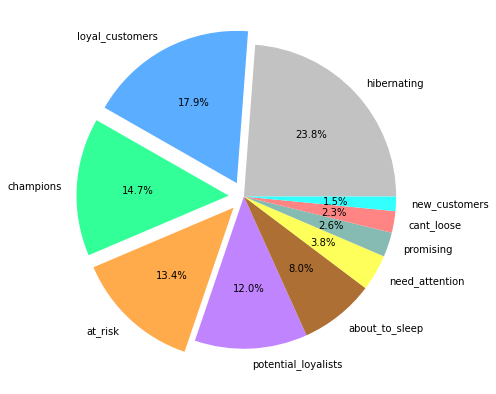

In [41]:
colors = ['#C2C2C2', '#5BADFF', '#33FF99', '#FFAB4B', 
          '#C184FF', '#AD6F33','#FFFF5B','#85BBB2',
          '#FF8484','#33FFFF']

fig1, ax1 = plt.subplots(figsize=(10,7))

ax1.pie(RFM_data["count"] ,labels=RFM_data["RFM_Segment"].unique() ,colors=colors, 
        explode=[0,0.1,0.1,0.1,0,0,0,0,0,0] ,autopct='%1.1f%%');

#### I am gonna give suggestion for each category of customer.

## 1) Champions

#### For this category, to keep this customer interest with your company, It is recommended to give award for any purchased product, such as point that may interest them to buy things at your company. This point can be exhange with discount or any other things that may interest them.

## 2) Potential Loyal

#### Same as previous category, this kind of customer which new customer with frequent purchase. To keep the customer spending on your company, you can give points for every purchase. With particular point accumulation, they can ranked up to 'loyal spender' category, before they grow interest to another company.

## 3) Loyal Customer

#### This customer have been loyal to the company.However, this customer better to be appriciated, I suggest the company may give this customer few incentive.

## 4) New Customer

#### For new customer, we do not really understand their behaviour. Therefore, the company may promote things that interest this customer from their previous purchase.

## 5) About To Sleep

#### This customer have frequently purchased at this company. However, it is been a long time since this customer purchased at this company. I recommend the company to promote the company or the product to notify this customer to shop more at this company.

## 6) Can Not Lose Them & Hibernating

#### The customer not so different with the previous category. However, this customer may not visit the website or application of this company longer. Therefore, it might be better for the company to promote its company or product by sending it to the email of the customer.

## 7) Promising & Loyal Spender

#### Same as previous category, to keep the customer spending on your company, you can give points for particular purchase. With particular point accumulation, they can ranked up to 'best customer' category.

# CONCLUSION

#### I recommend to take appropriate marketing action based on the segment of customer to keep them enganged and keep generating profit.